In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
# Load the Z boson dataset
df = pd.read_csv('/home/bhanda25/Phys323_fall2024/Root_files/Z_boson.csv')
df['class'] = df['class'].map({'Zee': 0, 'Zmumu': 1})
df = df.drop(['Unnamed: 0'], axis=1) # remove unwanted column

# Separate features and target variable
X = df.drop(['class'], axis=1).values  # Features
Y = df['class'].values  # Target

In [2]:
X

array([[ 1.66784000e+05,  2.02573290e+07,  4.29130000e+01, ...,
        -6.62400000e-01,  3.48500000e-01,  1.00000000e+00],
       [ 1.63261000e+05,  6.46798560e+07,  3.98744000e+01, ...,
         1.37100000e+00,  2.29520000e+00,  1.00000000e+00],
       [ 1.65570000e+05,  1.96860468e+08,  7.29296000e+01, ...,
        -2.68000000e-01, -1.46290000e+00,  1.00000000e+00],
       ...,
       [ 1.73389000e+05,  6.87651225e+08,  3.52640000e+01, ...,
        -1.81510000e+00,  2.91260000e+00, -1.00000000e+00],
       [ 1.72163000e+05,  1.91162958e+08,  3.89526000e+01, ...,
        -2.18040000e+00, -1.08170000e+00,  1.00000000e+00],
       [ 1.66895000e+05,  1.58156605e+08,  3.79928000e+01, ...,
         3.32000000e-02,  6.63100000e-01,  1.00000000e+00]])

In [3]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)  # Fit on training data and transform
X_test = sc.transform(X_test)        # Only transform the test data

#Split the training set into training and validation data point to ensure the model works well with unseen data.
#validation plot later on will saves us from overfitting training data, tunning hyperparameters,etc. 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=123)

# Convert numpy arrays to PyTorch tensors and ensure they are of type float32
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
X_val= torch.from_numpy(X_val.astype(np.float32))
Y_train = torch.from_numpy(Y_train.astype(np.float32))
Y_test = torch.from_numpy(Y_test.astype(np.float32))
Y_val=torch.from_numpy(Y_val.astype(np.float32))

# Reshape target tensors to be column vectors (necessary for binary classification)
Y_train = Y_train.view(Y_train.shape[0], 1)
Y_test = Y_test.view(Y_test.shape[0], 1)
Y_val= Y_val.view(Y_val.shape[0], 1)

In [12]:
# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)  # Single layer

    def forward(self, x):
        return self.linear(x)  # No sigmoid here (use BCEWithLogitsLoss)


# Get the number of features
n_features = X_train.shape[1]
print(n_features)
# Create an instance of the model
model = LogisticRegression(n_features)

# 2. Define loss function and optimizer
learning_rate = 0.01
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer

10


In [13]:


# 3. Training loop
num_epochs = 100  # Set the number of training epochs

# Lists to store loss and accuracy values for plotting
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Loop over epochs
for epoch in range(num_epochs):
    # Forward pass on the training data
    y_predicted_train = model(X_train)
    train_loss = criterion(y_predicted_train, Y_train)  # Compute training loss
    train_loss_values.append(train_loss.item())  # Save training loss for plotting
    
    # Backward pass (compute gradients)
    train_loss.backward()
    
    # Update the weights using the optimizer
    optimizer.step()
    
    # Zero the gradients after updating to prevent accumulation
    optimizer.zero_grad()

    # Calculate training accuracy: accuracy = Total number of correct prediction /total prediction
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        y_predicted_train_cls = y_predicted_train.round()  # Convert probabilities to class labels (0 or 1)
        
        train_acc = y_predicted_train_cls.eq(Y_train).sum().item() / float(Y_train.shape[0])  
        #the eq() function creates a boolean tensor where each element is True if the corresponding predicted label matches the true label, and False otherwise

        train_accuracy_values.append(train_acc)

    # Validation phase (evaluate the model on the test set)
    with torch.no_grad():
        y_predicted_val = model(X_val)  # Predict on val data
        val_loss = criterion(y_predicted_val, Y_val)  # Compute validation loss
        val_loss_values.append(val_loss.item())  # Save validation loss for plotting
        
        # Calculate validation accuracy
        y_predicted_val_cls = y_predicted_val.round()  # Convert probabilities to class labels (0 or 1)
        val_acc = y_predicted_val_cls.eq(Y_val).sum().item() / float(Y_val.shape[0])  # Calculate accuracy
        val_accuracy_values.append(val_acc)

    # Print training and validation metrics every 10 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch: {epoch + 1}, Train Loss = {train_loss.item():.4f}, '
              f'Validation Loss = {val_loss.item():.4f}, '
              f'Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}')



Epoch: 2, Train Loss = 0.7347, Validation Loss = 0.7228, Train Accuracy = 0.3277, Validation Accuracy = 0.3419
Epoch: 4, Train Loss = 0.7340, Validation Loss = 0.7220, Train Accuracy = 0.3282, Validation Accuracy = 0.3419
Epoch: 6, Train Loss = 0.7333, Validation Loss = 0.7213, Train Accuracy = 0.3285, Validation Accuracy = 0.3425
Epoch: 8, Train Loss = 0.7326, Validation Loss = 0.7206, Train Accuracy = 0.3290, Validation Accuracy = 0.3463
Epoch: 10, Train Loss = 0.7320, Validation Loss = 0.7199, Train Accuracy = 0.3302, Validation Accuracy = 0.3475
Epoch: 12, Train Loss = 0.7313, Validation Loss = 0.7192, Train Accuracy = 0.3312, Validation Accuracy = 0.3475
Epoch: 14, Train Loss = 0.7307, Validation Loss = 0.7185, Train Accuracy = 0.3331, Validation Accuracy = 0.3488
Epoch: 16, Train Loss = 0.7300, Validation Loss = 0.7178, Train Accuracy = 0.3336, Validation Accuracy = 0.3494
Epoch: 18, Train Loss = 0.7294, Validation Loss = 0.7171, Train Accuracy = 0.3340, Validation Accuracy = 0.3

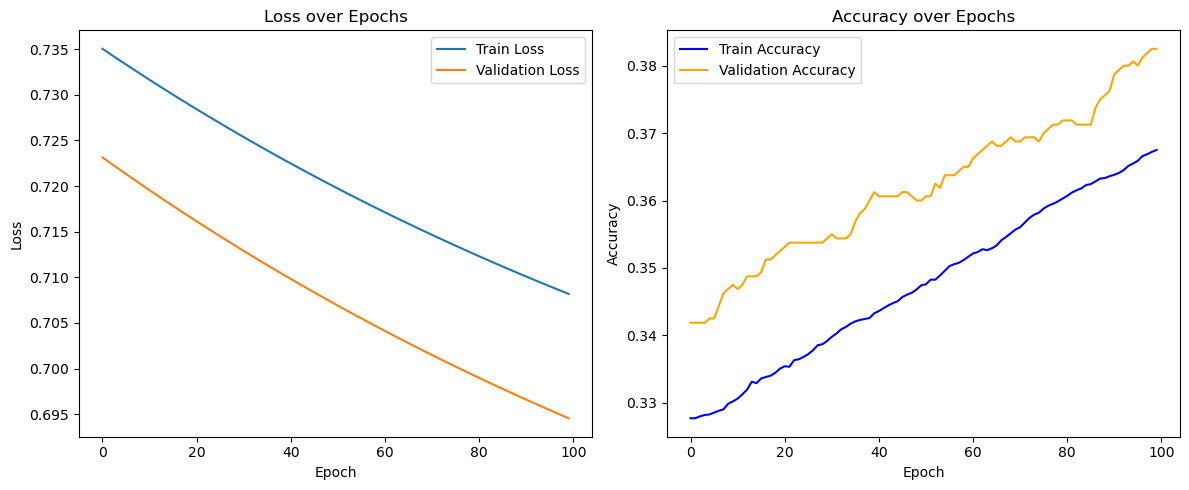

In [14]:
# 4. Plotting the training and validation metrics over epochs

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 5))  # Set the figure size for better visibility

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')  # Plot training loss
plt.plot(val_loss_values, label='Validation Loss')  # Plot validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Train Accuracy', color='blue')  # Plot training accuracy
plt.plot(val_accuracy_values, label='Validation Accuracy', color='orange')  # Plot validation accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()  # Adjust subplot layout
plt.show()  # Display the plot



Logistic regression is effective **only when the dataset is linearly separable**. However, the provided datasets including many real-world problems are often **complex and non-linear**, requiring more powerful models. 

To handle such **non-linearity**, we introduce **neural networks** with multiple hidden layers and **non-linear activation functions** like **ReLU**. This allows the model to **capture intricate patterns** in the data, leading to **better classification accuracy**.

## 🚀 Neural Network Model with Non-Linearity

Here’s an example of a neural network that can be used instead of logistic regression for improved classification performance.

```python
import torch
import torch.nn as nn
import torch.optim as optim

# Neural Network Model with Non-Linearity
class NeuralNetwork(nn.Module):
    def __init__(self, n_input_features):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input_features, 64),  # First hidden layer (64 neurons)
            nn.ReLU(),                        # Non-linear activation
            nn.Linear(64, 32),                # Second hidden layer (32 neurons)
            nn.ReLU(),                        # Non-linear activation
            nn.Linear(32, 16),                # Third hidden layer (16 neurons)
            nn.ReLU(),                        # Non-linear activation
            nn.Linear(16, 1),                 # Output layer (1 neuron)
            nn.Sigmoid()                      # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.model(x)

# Get the number of features from training data
n_features = X_train.shape[1]
print(f"Number of input features: {n_features}")

# Create an instance of the model
model = NeuralNetwork(n_features)

# Define loss function and optimizer
learning_rate = 0.01
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
